
# Tutorial 5: Model Evaluation with Uncertainty, Calibration & Robustness


**What you'll do:**
1. Load data and split data (LabelEncoder on `activity`, subject-based splits & CV).
2. Evaluate core classification metrics (**accuracy, precision, recall, balanced accuracy, F1**) — with intuitive examples.
3. Quantify **uncertainty** with **entropy, NLL (log-loss), Brier score**, and **calibration** via **ECE/MCE** + **reliability diagrams**.
4. **Calibrate** probabilities (Platt & temperature scaling) and *see* how ECE/NLL change.
5. Assess **robustness**: bootstrap confidence intervals & stress tests (Gaussian noise, missingness).



## Main Metric Summarization (what/why/how to use)
- **Accuracy**: Fraction of correct labels. *Can hide poor minority-class performance* if data are imbalanced.
- **Precision (macro)**: For each class, among predicted positives, how many are correct. *Penalizes false positives*. Macro = average across classes.
- **Recall (macro)**: For each class, among true positives, how many you found. *Penalizes false negatives*. Macro = average.
- **Balanced Accuracy**: Average of per-class recall. *Fair when classes are imbalanced*, unlike plain accuracy.
- **F1 (macro)**: Harmonic mean of precision and recall per class, then averaged. *Balances FP vs FN*.
- **Confusion Matrix**: Counts of (true, predicted) by class. *Use to see which classes are confused*.

**Probabilistic / Uncertainty / Calibration**
- **Predictive Entropy**: Uncertainty of the predicted probability vector. *High when model is unsure (probabilities spread out)*.
- **NLL / Log Loss**: Measures the difference between a model's predicted probabilities and the actual outcome. Punishes **overconfident wrong** predictions heavily. *Measures probability quality, not just argmax*.
- **Brier Score**: Squared error between predicted probabilities and one-hot truth. *Bounded & interpretable.*
- **ECE / MCE**: Expected / maximum calibration error. *How well confidences match reality*. Visualize with **reliability diagrams** (perfect = diagonal).


## 1) Setup & imports

In [2]:

# %pip install -q -U pandas numpy scikit-learn matplotlib seaborn
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, balanced_accuracy_score,
    f1_score, confusion_matrix, log_loss
)
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
from sklearn.calibration import CalibratedClassifierCV


## 2) Load the dataset

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Colab Data/ai_in_rehab_2025_tutorial/'
load_path = data_path + 'features_df_10s_3s.csv'

In [4]:
data_path = Path('./Features/')
load_path = data_path / 'features_df_10s_3s.csv'

In [5]:
features_df = pd.read_csv(load_path)

print(f"Loaded features_df from {load_path}")
print(features_df.shape)
display(features_df.head())


Loaded features_df from Features\features_df_10s_3s.csv
(8403, 64)


,subject,activity,trial,window,acc_x_mean,acc_x_std,acc_x_ptp,acc_x_skew,acc_x_kurtosis,acc_x_max,...,gyro_z_mean,gyro_z_std,gyro_z_ptp,gyro_z_skew,gyro_z_kurtosis,gyro_z_max,gyro_z_min,gyro_z_rms,gyro_z_dom_freq,gyro_z_dom_power
0,sub_1,downstairs,dws_2,0,-0.023998,0.283579,2.313090,-0.389540,2.053978,1.087611,...,0.200601,0.702851,4.235752,0.401193,0.628829,2.484049,-1.751703,0.730917,1.0,7731.701629
1,sub_1,downstairs,dws_2,1,-0.031795,0.272414,2.094176,-0.362455,1.670366,0.868698,...,0.172241,0.637546,3.888201,-0.066714,0.607222,2.102682,-1.785519,0.660403,2.5,3244.326669
2,sub_1,downstairs,dws_2,2,-0.034379,0.269779,2.094176,-0.439600,2.064346,0.868698,...,0.202481,0.682044,4.078817,0.223416,0.457288,2.293299,-1.785519,0.711465,1.0,6322.854542
3,sub_1,downstairs,dws_2,3,-0.043502,0.250859,1.744506,-0.026250,0.722650,0.726684,...,0.166020,0.594518,4.078817,0.101985,1.195871,2.293299,-1.785519,0.617263,2.0,2660.482244
4,sub_1,downstairs,dws_2,4,-0.042466,0.251274,1.744506,-0.124765,0.810124,0.726684,...,0.204300,0.623529,3.760722,0.380127,0.777102,2.293299,-1.467423,0.656145,1.0,5630.895696


## 3) Prepare and process data

In [6]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(features_df['activity'])

X = features_df.drop(['activity', 'subject', 'trial', 'window'], axis=1).to_numpy()
subjects = features_df['subject'].to_numpy()

print('X shape:', X.shape, '| #classes:', len(label_encoder.classes_))


X shape: (8403, 60) | #classes: 6



## 4) Subject-based split (GroupShuffleSplit) and evaluation

We split by **subject** so the model is tested on **unseen people** (more realistic generalization).


=== Subject-wise Test Metrics ===
Accuracy           : 95.83%  -> Overall correctness
Precision (macro)  : 93.62%  -> Low if many false positives
Recall (macro)     : 94.93%  -> Low if many false negatives
Balanced Accuracy  : 94.93%  -> Mean per-class recall (good for imbalance)
F1-macro           : 94.23%  -> Harmonic mean of precision/recall per class


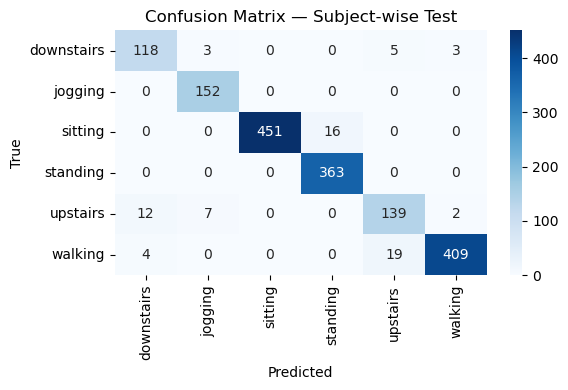

In [16]:

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=subjects))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
subjects_train, subjects_test = subjects[train_idx], subjects[test_idx]

model = RandomForestClassifier(n_estimators=10, max_depth=None, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
bal = balanced_accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')

print('=== Subject-wise Test Metrics ===')
print(f'Accuracy           : {100*acc:.2f}%  -> Overall correctness')
print(f'Precision (macro)  : {100*prec:.2f}%  -> Low if many false positives')
print(f'Recall (macro)     : {100*rec:.2f}%  -> Low if many false negatives')
print(f'Balanced Accuracy  : {100*bal:.2f}%  -> Mean per-class recall (good for imbalance)')
print(f'F1-macro           : {100*f1m:.2f}%  -> Harmonic mean of precision/recall per class')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Subject-wise Test")
plt.tight_layout(); plt.show()



### 4.1 Metric intuition with **mini-examples**
These toy cases show *why* we track multiple metrics.

**A) Imbalance: same accuracy, different fairness**  
We build an imbalanced set (95% class A). A dumb classifier predicting only A has **95% accuracy** but **balanced accuracy = 50%**.


In [8]:

# A) Imbalance example
y_true = np.array([0]*95 + [1]*5)   # 95% class 0
y_pred_all_zero = np.array([0]*100) # predict all 0

acc = accuracy_score(y_true, y_pred_all_zero)
bal = balanced_accuracy_score(y_true, y_pred_all_zero)
print(f'Accuracy={100*acc:.1f}% vs Balanced Accuracy={100*bal:.1f}%  (reveals failure on minority class)')


Accuracy=95.0% vs Balanced Accuracy=50.0%  (reveals failure on minority class)



**B) Same accuracy, different probability quality**  
Two models get 80% accuracy, but one is **overconfident** on its mistakes. **NLL** and **Brier** expose this.


In [9]:

rng = np.random.RandomState(0)
n = 100
y_true = rng.randint(0, 2, size=n)

# Build equal accuracy: 80% correct predictions
correct_mask = rng.rand(n) < 0.8
y_pred_label = np.where(correct_mask, y_true, 1 - y_true)

# Model 1: Overconfident (p=0.99 for predicted label)
proba1 = np.zeros((n,2)); proba1[np.arange(n), y_pred_label] = 0.99; proba1[np.arange(n), 1-y_pred_label] = 0.01
# Model 2: Modest confidence (p=0.60 for predicted label)
proba2 = np.zeros((n,2)); proba2[np.arange(n), y_pred_label] = 0.60; proba2[np.arange(n), 1-y_pred_label] = 0.40

def brier_binary(y, p):
    Y = np.eye(2)[y]
    return np.mean(np.sum((p - Y)**2, axis=1))

def nll_binary(y, p):
    return log_loss(y, p, labels=[0,1])

print('Accuracy both:', accuracy_score(y_true, y_pred_label))
print('Overconfident — NLL:', nll_binary(y_true, proba1), 'Brier:', brier_binary(y_true, proba1))
print('Modest conf.  — NLL:', nll_binary(y_true, proba2), 'Brier:', brier_binary(y_true, proba2))
print('=> Overconfidence is punished by NLL/Brier even at same accuracy.')


Accuracy both: 0.81
Overconfident — NLL: 0.8831231073790734 Brier: 0.37260000000000004
Modest conf.  — NLL: 0.5878639943065419 Brier: 0.3960000000000001
=> Overconfidence is punished by NLL/Brier even at same accuracy.



**C) Entropy tracks uncertainty**  
High entropy ↔ probabilities spread out (uncertain). Low entropy ↔ one class dominates (confident).


In [10]:

def entropy_row(p, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p*np.log(p), axis=1)

p_sure = np.array([[0.99, 0.01],
                   [0.98, 0.02],
                   [0.97, 0.03]])
p_unsure = np.array([[0.51, 0.49],
                     [0.55, 0.45],
                     [0.60, 0.40]])

print('Entropy (confident):', entropy_row(p_sure))
print('Entropy (uncertain):', entropy_row(p_unsure))


Entropy (confident): [0.05600153 0.09803911 0.13474217]
Entropy (uncertain): [0.69294717 0.68813881 0.67301167]



## 5) Uncertainty & calibration on the **subject-wise test**
We now compute uncertainty metrics on real test predictions and visualize calibration.


In [17]:

proba_test = model.predict_proba(X_test)

def predictive_entropy(p: np.ndarray, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def brier_multiclass(y_true, proba, n_classes):
    Y = np.eye(n_classes)[y_true]
    return np.mean(np.sum((proba - Y)**2, axis=1))

def ece_score(y_true, proba, n_bins=15):
    preds = proba.argmax(axis=1)
    confidences = proba.max(axis=1)
    correctness = (preds == y_true).astype(int)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(confidences, bins) - 1
    ece, mce = 0.0, 0.0
    for b in range(n_bins):
        mask = (idx == b)
        if mask.sum() == 0: 
            continue
        acc = correctness[mask].mean()
        conf = confidences[mask].mean()
        w = mask.mean()
        ece += w * abs(acc - conf)
        mce = max(mce, abs(acc - conf))
    return ece, mce

entropy = predictive_entropy(proba_test)
try:
    nll = log_loss(y_test, proba_test, labels=np.arange(len(label_encoder.classes_)))
except Exception:
    nll = np.nan
brier = brier_multiclass(y_test, proba_test, n_classes=len(label_encoder.classes_))
ece, mce = ece_score(y_test, proba_test, n_bins=15)

print('Entropy (mean):', float(entropy.mean()))
print('NLL:', float(nll), ' — lower is better; punishes overconfident wrong predictions')
print('Brier:', float(brier), ' — lower is better; squared error of probabilities')
print('ECE:', float(ece), ' MCE:', float(mce), ' — closer to 0 is better (well-calibrated)')


Entropy (mean): 0.31163280932873366
NLL: 0.20494142093935486  — lower is better; punishes overconfident wrong predictions
Brier: 0.09398708162066942  — lower is better; squared error of probabilities
ECE: 0.08778625954198468  MCE: 0.26065573770491823  — closer to 0 is better (well-calibrated)


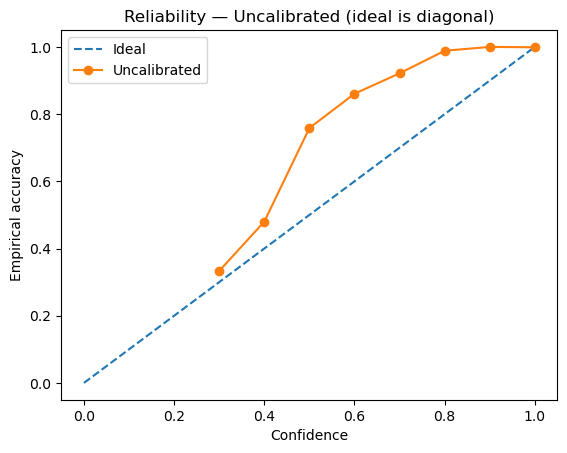

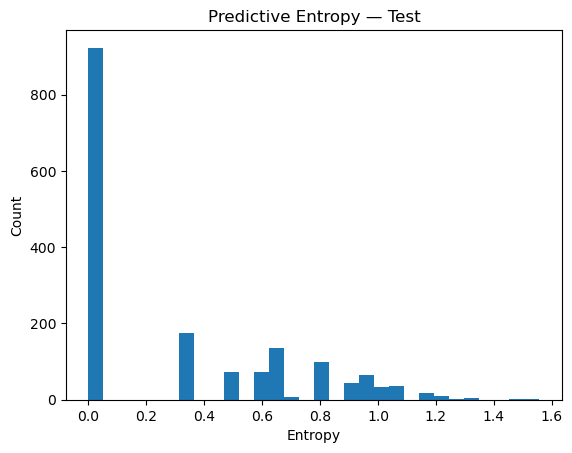

In [18]:
def plot_reliability_diagram(y_true, proba, n_bins=15, title='Reliability Diagram'):
    preds = proba.argmax(axis=1)
    conf = proba.max(axis=1)
    correct = (preds == y_true).astype(int)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    accs, confs = [], []
    for b in range(n_bins):
        m = (conf >= bins[b]) & (conf < bins[b+1]) if b < n_bins-1 else (conf >= bins[b]) & (conf <= bins[b+1])
        if m.sum() == 0:
            accs.append(np.nan); confs.append(np.nan)
        else:
            accs.append(correct[m].mean()); confs.append(conf[m].mean())
    plt.figure(); plt.plot([0,1],[0,1],'--', label="Ideal")
    plt.plot([c for c in confs if not np.isnan(c)], [a for a in accs if not np.isnan(a)], marker='o',label="Uncalibrated")
    plt.xlabel('Confidence'); plt.ylabel('Empirical accuracy'); plt.title(title + ' (ideal is diagonal)'); plt.legend(); plt.show()

plot_reliability_diagram(y_test, proba_test, n_bins=15, title='Reliability — Uncalibrated')
plt.figure(); plt.hist(entropy, bins=30); plt.xlabel('Entropy'); plt.ylabel('Count'); plt.title('Predictive Entropy — Test')
plt.show()



## 6) What is **Model Calibration**? (Plain-English + How to Read It)

**Calibration** means: *when the model says “X% confident,” it should be right about X% of the time.*  
A perfectly calibrated classifier's confidence values match reality.

### Why it matters
- **Decision thresholds**: If 0.8 probability truly means ~80% success, you can set thresholds for deployment, triage, or human-in-the-loop.
- **Risk-sensitive apps**: Overconfident wrong predictions can be dangerous; **NLL** and **ECE** make this visible.
- **Comparability**: Two models with the same accuracy can have very different probability quality.

### Typical symptoms
- **Overconfidence**: Model predicts high probabilities but accuracy in those bins is lower.  
  *Reliability curve sits **below** the diagonal; ECE is high.*
- **Underconfidence**: Probabilities are conservative; accuracy sits **above** the curve.  
  *Reliability curve sits **above** the diagonal.*

### How we measure & visualize
- **Reliability diagram**: Bin predictions by **max probability**; for each bin plot (mean confidence, empirical accuracy).  
  *Perfectly calibrated → points on the diagonal y=x.*
- **ECE (Expected Calibration Error)**: Weighted average gap between confidence and accuracy across bins (↓ better).
- **NLL (Log loss)**: Punishes **overconfident mistakes** heavily (↓ better). Complements ECE.
- **Brier score**: Squared error between predicted probabilities and one-hot truth (↓ better).

### How to improve calibration
- **Post-hoc calibration** on a **held-out validation set**:
  - **Platt scaling (sigmoid)**: A simple logistic mapping per class (or OvR). Often effective for slight overconfidence.
  - **Temperature scaling**: Scales logits by \(1/T\); tunes **T** to minimize **NLL**. Preserves ranking, usually reduces overconfidence.
  - *(Also exists: Isotonic regression — flexible but needs more data and can overfit.)*
- **Good practice**: Use a **subject-wise** validation split (matching train/test protocol) to fit calibration, then **evaluate on the held-out test**.

*Below we fit Platt & Temperature on a subject-wise validation split and compare ECE/NLL & reliability curves before vs after.*



## 6) Calibration (Platt & Temperature) — see ECE/NLL improve
We create a **subject-wise validation split** from the training set to fit calibration and compare on the held-out test.


Optimal temperature (validation): [0.1]
Uncalibrated — NLL: 0.1692  |  ECE: 0.0773
Platt        — NLL: 0.0931  |  ECE: 0.0155
Temperature  — NLL: 0.1639  |  ECE: 0.0175


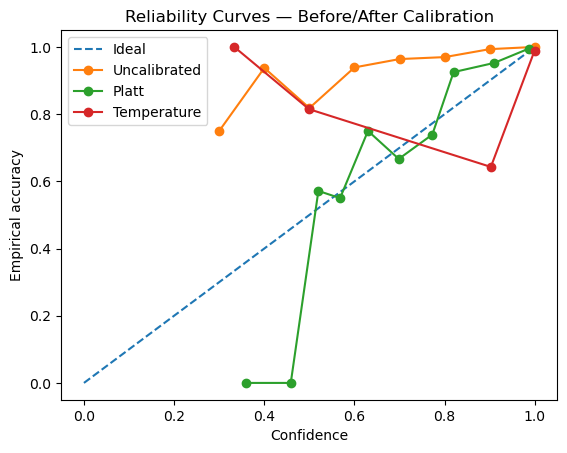

In [19]:

from sklearn.model_selection import GroupShuffleSplit

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss_val.split(X_train, y_train, groups=subjects_train))
X_tr, X_val = X_train[tr_idx], X_train[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

base_model = RandomForestClassifier(n_estimators=10, max_depth=None, n_jobs=-1, random_state=42)
base_model.fit(X_tr, y_tr)

# sklearn>=1.2 uses `estimator`; older versions used `base_estimator`.
try:
    platt = CalibratedClassifierCV(estimator=base_model, cv='prefit', method='sigmoid')
except TypeError:
    platt = CalibratedClassifierCV(base_estimator=base_model, cv='prefit', method='sigmoid')
platt.fit(X_val, y_val)

def softmax(z, axis=1):
    z = z - np.max(z, axis=axis, keepdims=True)
    ez = np.exp(z)
    return ez / np.sum(ez, axis=axis, keepdims=True)

def temperature_scale(proba, T):
    eps=1e-12
    logp = np.log(np.clip(proba, eps, 1.0))
    return softmax(logp / T, axis=1)

def best_T(proba, y_true, grid=np.linspace(0.1, 0.5, 1, 5.0, 10)):
    Y = np.eye(len(label_encoder.classes_))[y_true]
    best_T, best_nll = 1.0, np.inf
    for T in grid:
        pT = temperature_scale(proba, T)
        nll = -np.mean(np.sum(Y * np.log(np.clip(pT, 1e-12, 1.0)), axis=1))
        if nll < best_nll:
            best_nll, best_T = nll, T
    return best_T

proba_val_base = base_model.predict_proba(X_val)
T_opt = best_T(proba_val_base, y_val)
print('Optimal temperature (validation):', T_opt)

proba_test_base  = base_model.predict_proba(X_test)
proba_test_platt = platt.predict_proba(X_test)
proba_test_T     = temperature_scale(proba_test_base, T_opt)

def quick_ece(y_true, proba, n_bins=15):
    preds = proba.argmax(axis=1)
    confidences = proba.max(axis=1)
    correctness = (preds == y_true).astype(int)
    bins = np.linspace(0.0,1.0,n_bins+1)
    idx = np.digitize(confidences, bins)-1
    ece=0.0
    for b in range(n_bins):
        m=(idx==b)
        if m.sum()==0: continue
        acc=correctness[m].mean(); conf=confidences[m].mean(); w=m.mean()
        ece += w*abs(acc-conf)
    return ece

for name, p in [('Uncalibrated', proba_test_base),
                ('Platt', proba_test_platt),
                ('Temperature', proba_test_T)]:
    try:
        nll = log_loss(y_test, p, labels=np.arange(len(label_encoder.classes_)))
    except Exception:
        nll = np.nan
    ece = quick_ece(y_test, p, n_bins=15)
    print(f'{name:<12} — NLL: {nll:.4f}  |  ECE: {ece:.4f}')

def plot_rel_curves(y_true, proba_list, labels, n_bins=15, title='Calibration Comparison'):
    plt.figure()
    plt.plot([0,1],[0,1],'--', label='Ideal')
    for proba, lab in zip(proba_list, labels):
        preds = proba.argmax(axis=1)
        conf = proba.max(axis=1)
        correct = (preds == y_true).astype(int)
        bins = np.linspace(0.0, 1.0, n_bins+1)
        xs, ys = [], []
        for b in range(n_bins):
            m = (conf >= bins[b]) & (conf < bins[b+1]) if b < n_bins-1 else (conf >= bins[b]) & (conf <= bins[b+1])
            if m.sum()==0: continue
            xs.append(conf[m].mean()); ys.append(correct[m].mean())
        plt.plot(xs, ys, marker='o', label=lab)
    plt.xlabel('Confidence'); plt.ylabel('Empirical accuracy'); plt.title(title)
    plt.legend(); plt.show()

plot_rel_curves(y_test,
                [proba_test_base, proba_test_platt, proba_test_T],
                ['Uncalibrated','Platt','Temperature'],
                n_bins=15, title='Reliability Curves — Before/After Calibration')



## 7) Robustness — Bootstrap confidence intervals (CI)
**Why:** Metrics vary with sample; bootstrap resamples the **test set** to estimate variability and 95% CI.


,mean,std,2.5%,50%,97.5%
acc,0.983326,0.003173,0.977099,0.983558,0.988843
f1_macro,0.969325,0.005886,0.956104,0.970254,0.979042
nll,0.170223,0.029117,0.123114,0.167949,0.235297
brier,0.062330,0.003910,0.055139,0.061856,0.070037
ece,0.077229,0.004290,0.068291,0.077422,0.084968


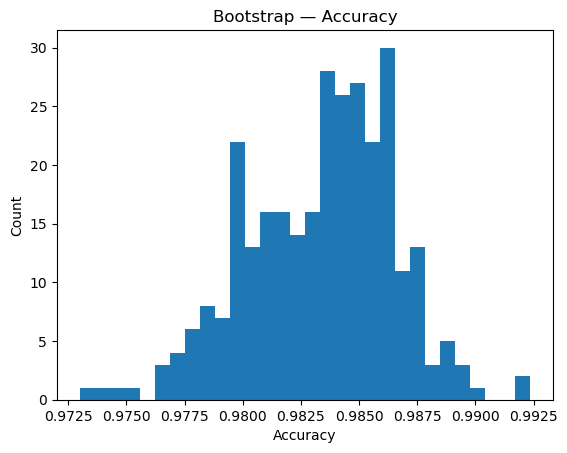

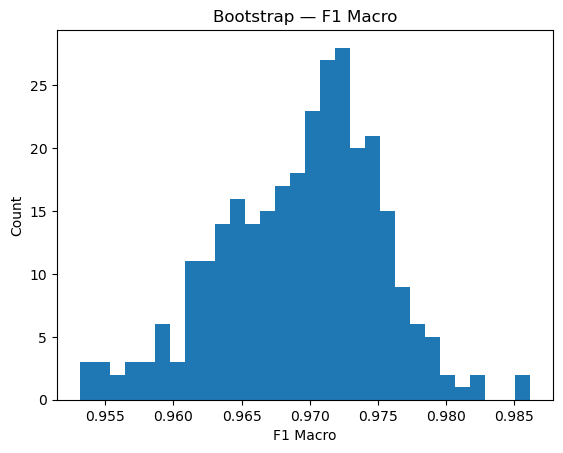

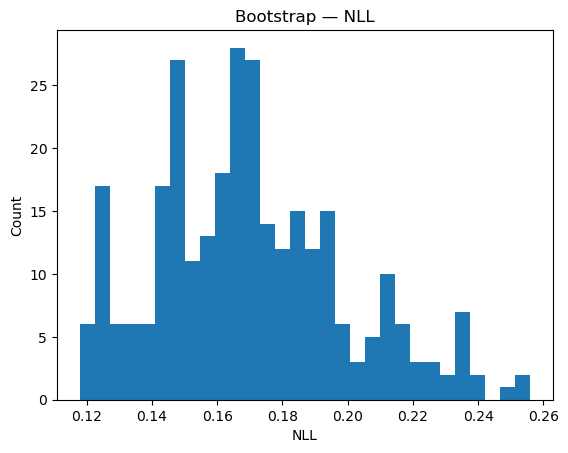

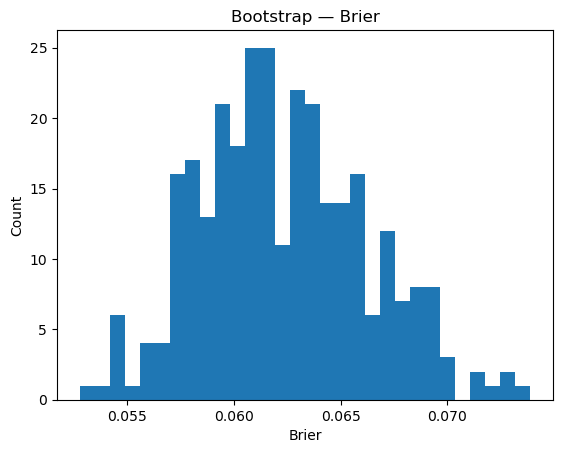

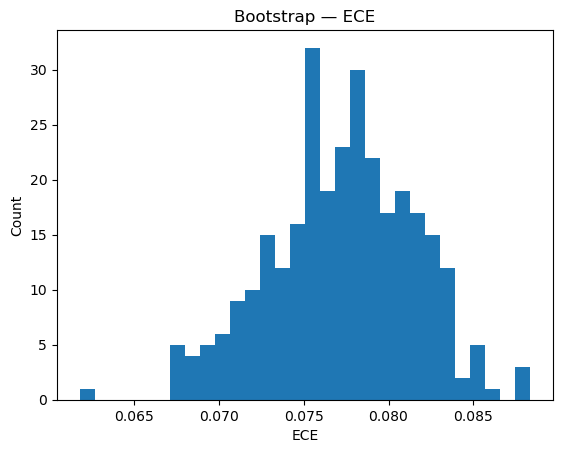

In [23]:

rng = np.random.RandomState(42)
B = 300
proba = proba_test_base
preds = proba.argmax(axis=1)
n_classes = proba.shape[1]
Y = np.eye(n_classes)[y_test]

def bootstrap_metrics(y_true, proba, preds, B=300, rng=None):
    rng = np.random.RandomState(42) if rng is None else rng
    accs, f1s, nlls, briers, eces = [], [], [], [], []
    for _ in range(B):
        idx = rng.randint(0, len(y_true), size=len(y_true))
        y_b = y_true[idx]
        p_b = proba[idx]
        pred_b = preds[idx]
        accs.append(accuracy_score(y_b, pred_b))
        f1s.append(f1_score(y_b, pred_b, average='macro'))
        try:
            nlls.append(log_loss(y_b, p_b, labels=np.arange(n_classes)))
        except Exception:
            nlls.append(np.nan)
        briers.append(np.mean(np.sum((p_b - Y[idx])**2, axis=1)))
        # ECE
        ece = 0.0
        conf = p_b.max(axis=1); correct = (p_b.argmax(axis=1) == y_b).astype(int)
        bins = np.linspace(0,1,16); idxb = np.digitize(conf, bins)-1
        for b in range(15):
            m = (idxb==b)
            if m.sum()==0: continue
            ece += m.mean() * abs(correct[m].mean() - conf[m].mean())
        eces.append(ece)
    return pd.DataFrame({'acc':accs,'f1_macro':f1s,'nll':nlls,'brier':briers,'ece':eces})

boot = bootstrap_metrics(y_test, proba, preds, B=B, rng=rng)
summary = boot.describe(percentiles=[0.025,0.5,0.975]).T
display(summary[['mean','std','2.5%','50%','97.5%']])

plt.figure(); plt.hist(boot['acc'].dropna(), bins=30); plt.title('Bootstrap — Accuracy'); plt.xlabel('Accuracy'); plt.ylabel('Count'); plt.show()
plt.figure(); plt.hist(boot['f1_macro'].dropna(), bins=30); plt.title('Bootstrap — F1 Macro'); plt.xlabel('F1 Macro'); plt.ylabel('Count'); plt.show()
plt.figure(); plt.hist(boot['nll'].dropna(), bins=30); plt.title('Bootstrap — NLL'); plt.xlabel('NLL'); plt.ylabel('Count'); plt.show()
plt.figure(); plt.hist(boot['brier'].dropna(), bins=30); plt.title('Bootstrap — Brier'); plt.xlabel('Brier'); plt.ylabel('Count'); plt.show()
plt.figure(); plt.hist(boot['ece'].dropna(), bins=30); plt.title('Bootstrap — ECE'); plt.xlabel('ECE'); plt.ylabel('Count'); plt.show()



## 8) Robustness — Stress tests (Gaussian noise & missingness)
**Why:** Probe sensitivity to small input shifts or dropouts, without retraining.


,sigma,acc,f1_macro,nll,ece
0,0.00,0.983558,0.969754,0.169247,0.077334
1,0.05,0.972989,0.957689,0.183842,0.090194
2,0.10,0.937170,0.912577,0.274955,0.118732
3,0.20,0.811509,0.771201,0.893731,0.105461
4,0.30,0.730476,0.682514,1.663929,0.093247


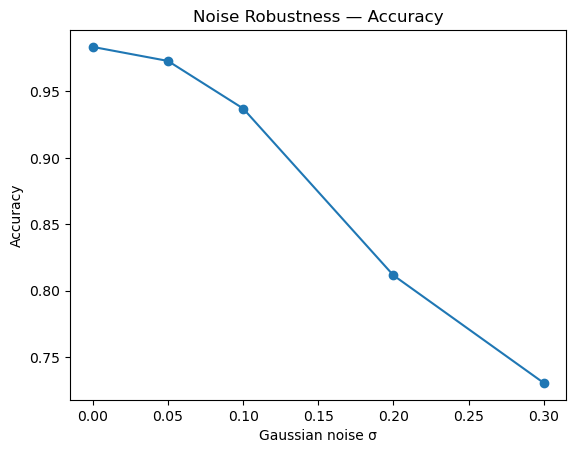

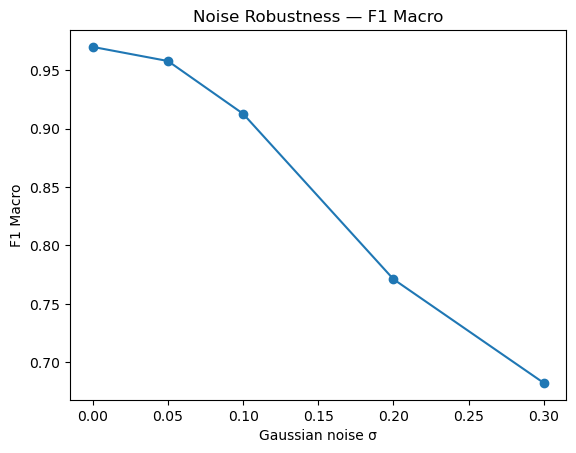

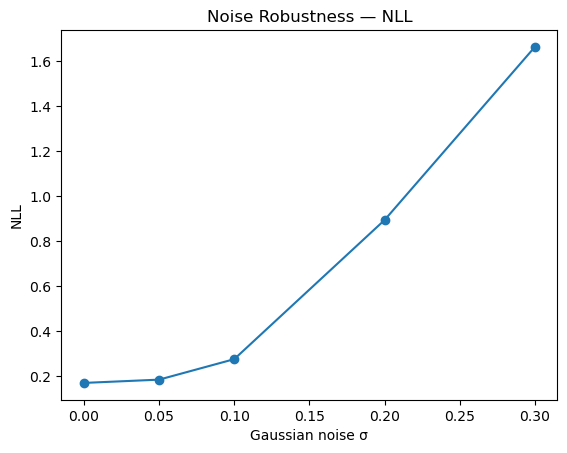

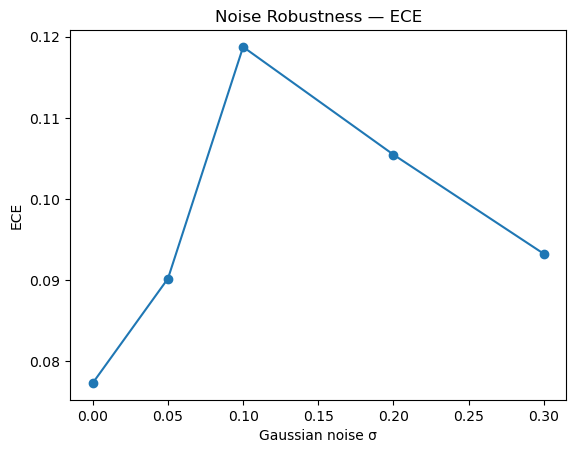

,p,acc,f1_macro,nll,ece
0,0.00,0.983558,0.969754,0.169247,0.077334
1,0.05,0.977686,0.963278,0.226399,0.115561
2,0.10,0.967704,0.951872,0.287635,0.148444
3,0.20,0.938344,0.913875,0.411965,0.199237
4,0.30,0.912507,0.885214,0.500630,0.246800


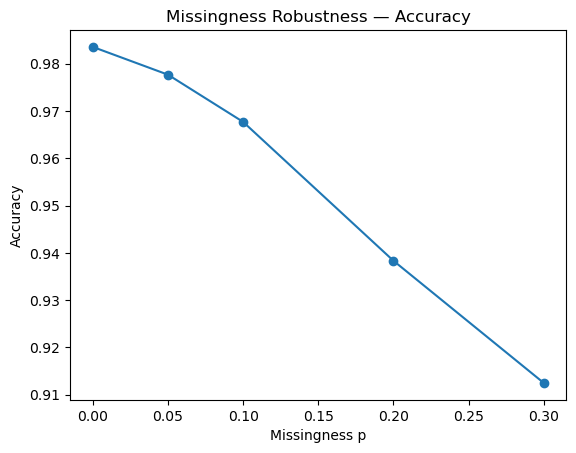

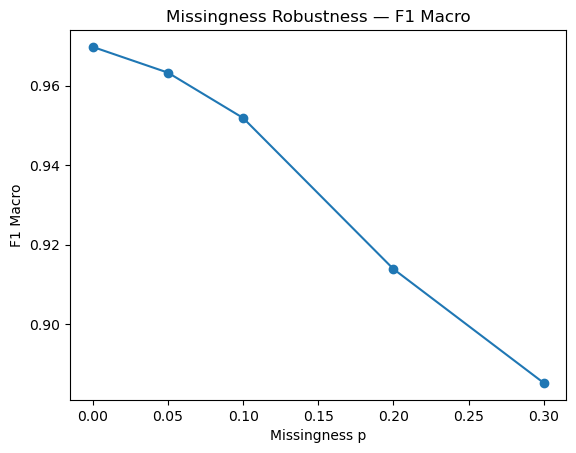

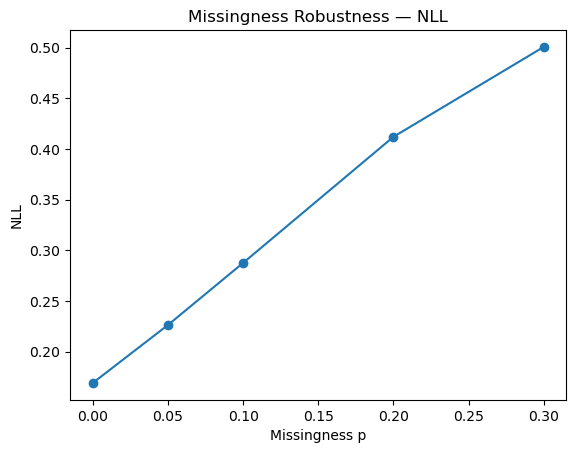

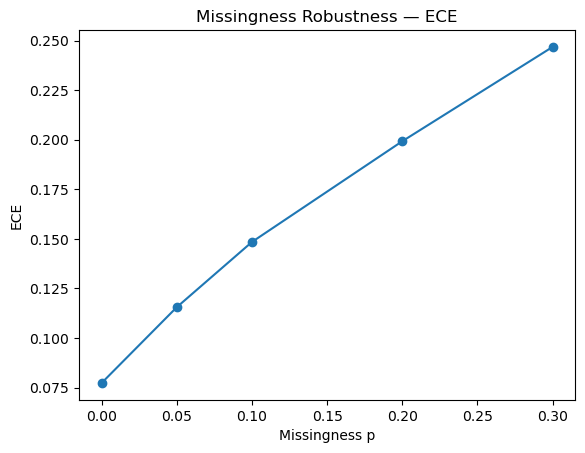

In [24]:

# We'll add Gaussian noise to X_test and also randomly mask entries as NaN, imputing with train means.
train_means = X_train.mean(axis=0)

def add_gaussian_noise(X, sigma=0.1, rng=None):
    rng = np.random.RandomState(42) if rng is None else rng
    return X + rng.normal(0, sigma, size=X.shape)

def random_missing_impute(X, p=0.05, rng=None, fill_vals=None):
    rng = np.random.RandomState(42) if rng is None else rng
    Xm = X.copy().astype(float, copy=False)
    mask = rng.rand(*Xm.shape) < p
    Xm[mask] = np.nan
    if fill_vals is None:
        fill_vals = np.nanmean(Xm, axis=0)
    inds = np.where(np.isnan(Xm))
    Xm[inds] = np.take(fill_vals, inds[1])
    return Xm

def eval_metrics_on(X_t, y_true, clf):
    proba = clf.predict_proba(X_t)
    preds = proba.argmax(axis=1)
    acc = accuracy_score(y_true, preds)
    f1m = f1_score(y_true, preds, average='macro')
    try:
        nll = log_loss(y_true, proba, labels=np.arange(proba.shape[1]))
    except Exception:
        nll = np.nan
    ece = quick_ece(y_true, proba, n_bins=15)
    return {'acc':acc, 'f1_macro':f1m, 'nll':nll, 'ece':ece}

sigmas = [0.0, 0.05, 0.1, 0.2, 0.3]
noise_rows = []
for s in sigmas:
    Xn = add_gaussian_noise(X_test, sigma=s)
    noise_rows.append(dict(sigma=s, **eval_metrics_on(Xn, y_test, base_model)))
noise_df = pd.DataFrame(noise_rows)
display(noise_df)

plt.figure(); plt.plot(noise_df['sigma'], noise_df['acc'], marker='o'); plt.xlabel('Gaussian noise σ'); plt.ylabel('Accuracy'); plt.title('Noise Robustness — Accuracy'); plt.show()
plt.figure(); plt.plot(noise_df['sigma'], noise_df['f1_macro'], marker='o'); plt.xlabel('Gaussian noise σ'); plt.ylabel('F1 Macro'); plt.title('Noise Robustness — F1 Macro'); plt.show()
plt.figure(); plt.plot(noise_df['sigma'], noise_df['nll'], marker='o'); plt.xlabel('Gaussian noise σ'); plt.ylabel('NLL'); plt.title('Noise Robustness — NLL'); plt.show()
plt.figure(); plt.plot(noise_df['sigma'], noise_df['ece'], marker='o'); plt.xlabel('Gaussian noise σ'); plt.ylabel('ECE'); plt.title('Noise Robustness — ECE'); plt.show()

ps = [0.0, 0.05, 0.1, 0.2, 0.3]
miss_rows = []
for p in ps:
    Xm = random_missing_impute(X_test, p=p, fill_vals=train_means)
    miss_rows.append(dict(p=p, **eval_metrics_on(Xm, y_test, base_model)))
miss_df = pd.DataFrame(miss_rows)
display(miss_df)

plt.figure(); plt.plot(miss_df['p'], miss_df['acc'], marker='o'); plt.xlabel('Missingness p'); plt.ylabel('Accuracy'); plt.title('Missingness Robustness — Accuracy'); plt.show()
plt.figure(); plt.plot(miss_df['p'], miss_df['f1_macro'], marker='o'); plt.xlabel('Missingness p'); plt.ylabel('F1 Macro'); plt.title('Missingness Robustness — F1 Macro'); plt.show()
plt.figure(); plt.plot(miss_df['p'], miss_df['nll'], marker='o'); plt.xlabel('Missingness p'); plt.ylabel('NLL'); plt.title('Missingness Robustness — NLL'); plt.show()
plt.figure(); plt.plot(miss_df['p'], miss_df['ece'], marker='o'); plt.xlabel('Missingness p'); plt.ylabel('ECE'); plt.title('Missingness Robustness — ECE'); plt.show()



## 10) Takeaways
- **Accuracy** alone can mislead on imbalanced data → check **balanced accuracy**, **per-class recall**, and the **confusion matrix**.
- **NLL** and **Brier** capture **probability quality** — they expose overconfidence even when accuracy is the same.
- **ECE/MCE** + **reliability diagrams** tell you if “70% confident” really means “~70% correct.”
- **Calibration** (Platt / temperature) often reduces ECE and NLL without changing accuracy.
- **Bootstrap** CIs quantify metric uncertainty; **stress tests** reveal brittleness to noise/missingness.


# Exercise

Can you do cross-validation for the temperature finetuning in model calibration? And show the (possible) improvement of calibrated prediction on the test set.